In [1]:
#!pip3 install neat-python

from keras.datasets import mnist
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:463: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:464: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:465: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

## Global Parameters

In [2]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 10

RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

# How many samples to test:
N_SAMPLES_TO_TEST = 200

# Simulation Parameters
NR_GENERATIONS =1000
CONFIG_FILE = 'NEAT-configs/mnist-wann'

## Load MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## Preprocess MNIST

### Trim down Dataset

In [4]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 60000
Testing samples remaining: 10000


### Rescale Images

In [5]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

### Normalize

In [6]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

### Visualize

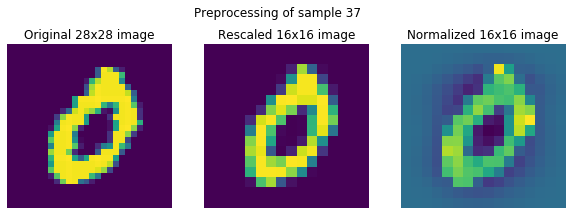

In [7]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [8]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

# NEAT

## Basic Run Function

In [9]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

def sigmoid(output):
    output = [min(709., x) for x in output]
    output = [max(-709., x) for x in output]
    return [1 /(1 + exp(-x)) for x in output]

In [10]:
def step(x):
    return 1.0*(x>0.0)

def cos(x):
    try:
        x = max(-60.0, min(60.0, 5.0 * x))
        return math.cos(x)
    except ValueError:
        print(x)
        

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    config.genome_config.add_activation('cos', cos)
    config.genome_config.add_activation('step', step)
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fitness_history.csv")
    
    with open('NEAT-results/best_genomes', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [11]:
def eval_genomes(genomes, config):
    
    def _cross_entropy(pred, label):
        return -np.log(exp(pred[label])/np.sum(exp(pred), axis=0))
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    
    for genome_id, genome in genomes:
        ce = []
        
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = net.activate(train)
            ce.append(-_cross_entropy(sigmoid(output), label))
#             if np.argmax(sigmoid(output)) == label:
#                 nr_correct += 1.

        genome.fitness = np.average(ce)         
 

In [ ]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

Population's average fitness: -2.32291 stdev: 0.02365
Best fitness: -2.25156 - size: (10, 128) - species 1 - id 50
Average adjusted fitness: 0.057
Mean genetic distance 2.328, standard deviation 0.204
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250     -2.3    0.057     0
Total extinctions: 0
Generation time: 15.568 sec

 ****** Running generation 1 ****** 

Population's average fitness: -2.30813 stdev: 0.02207
Best fitness: -2.24282 - size: (10, 128) - species 1 - id 118
Average adjusted fitness: 0.051
Mean genetic distance 2.337, standard deviation 0.275
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   250     -2.2    0.051     0
Total extinctions: 0
Generation time: 15.551 sec (15.560 average)

 ****** Running generation 2 ****** 

Population's average fitness: -2.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neat/activations.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  z = 1.0 / z


Population's average fitness: -2.29191 stdev: 0.02366
Best fitness: -2.23695 - size: (10, 127) - species 1 - id 783
Average adjusted fitness: 0.059
Mean genetic distance 1.491, standard deviation 0.944
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    3   250     -2.2    0.059     1
Total extinctions: 0
Generation time: 15.245 sec (15.369 average)

 ****** Running generation 4 ****** 

Population's average fitness: -2.29403 stdev: 0.02273
Best fitness: -2.22779 - size: (11, 128) - species 1 - id 1140
Average adjusted fitness: 0.056
Mean genetic distance 0.660, standard deviation 0.559
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    4   250     -2.2    0.056     0
Total extinctions: 0
Generation time: 15.304 sec (15.356 average)

 ****** Running generation 5 ****** 

Population's average fitness: -2.28314 stdev: 0.02197

Population's average fitness: -2.27074 stdev: 0.02631
Best fitness: -2.20088 - size: (11, 128) - species 1 - id 5449
Average adjusted fitness: 0.068
Mean genetic distance 0.546, standard deviation 0.149
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   21   250     -2.2    0.068     8
Total extinctions: 0
Generation time: 15.417 sec (15.267 average)

 ****** Running generation 22 ****** 

Population's average fitness: -2.27299 stdev: 0.02698
Best fitness: -2.19838 - size: (10, 124) - species 1 - id 5304
Average adjusted fitness: 0.075
Mean genetic distance 0.555, standard deviation 0.148
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   22   250     -2.2    0.075     9
Total extinctions: 0
Generation time: 15.150 sec (15.248 average)

 ****** Running generation 23 ****** 

Population's average fitness: -2.27062 stdev: 0.02

Population's average fitness: -2.25429 stdev: 0.02960
Best fitness: -2.17666 - size: (11, 120) - species 1 - id 9822
Average adjusted fitness: 0.088
Mean genetic distance 0.546, standard deviation 0.091
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   39   250     -2.2    0.088     0
Total extinctions: 0
Generation time: 15.204 sec (15.174 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-39

 ****** Running generation 40 ****** 

Population's average fitness: -2.26334 stdev: 0.02401
Best fitness: -2.18833 - size: (12, 124) - species 1 - id 9601
Average adjusted fitness: 0.072
Mean genetic distance 0.570, standard deviation 0.080
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   40   250     -2.2    0.072     1
Total extinctions: 0
Generation time: 15.137 sec (15.178 average)

 ****** Running gener

Mean genetic distance 0.612, standard deviation 0.108
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   56   250     -2.2    0.070     9
Total extinctions: 0
Generation time: 15.239 sec (15.241 average)

 ****** Running generation 57 ****** 

Population's average fitness: -2.26093 stdev: 0.02872
Best fitness: -2.18194 - size: (12, 120) - species 1 - id 13693
Average adjusted fitness: 0.077
Mean genetic distance 0.615, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   57   250     -2.2    0.077    10
Total extinctions: 0
Generation time: 15.162 sec (15.231 average)

 ****** Running generation 58 ****** 

Population's average fitness: -2.25665 stdev: 0.02411
Best fitness: -2.18577 - size: (12, 120) - species 1 - id 13693
Average adjusted fitness: 0.060
Mean genetic distance 0.674, standard deviation 

Population's average fitness: -2.24546 stdev: 0.02931
Best fitness: -2.16173 - size: (12, 113) - species 1 - id 18185
Average adjusted fitness: 0.077
Mean genetic distance 0.572, standard deviation 0.101
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   74   250     -2.2    0.077    15
Total extinctions: 0
Generation time: 15.070 sec (15.074 average)

 ****** Running generation 75 ****** 

Population's average fitness: -2.26651 stdev: 0.02850
Best fitness: -2.18888 - size: (11, 118) - species 1 - id 18436
Average adjusted fitness: 0.071
Mean genetic distance 0.592, standard deviation 0.090
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   75   250     -2.2    0.071    16
Total extinctions: 0
Generation time: 15.083 sec (15.073 average)

 ****** Running generation 76 ****** 

Population's average fitness: -2.24568 stdev: 0.

Population's average fitness: -2.23734 stdev: 0.03044
Best fitness: -2.14990 - size: (11, 110) - species 1 - id 22444
Average adjusted fitness: 0.104
Mean genetic distance 0.625, standard deviation 0.096
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   92   250     -2.1    0.104    14
Total extinctions: 0
Generation time: 15.178 sec (15.061 average)

 ****** Running generation 93 ****** 

Population's average fitness: -2.24219 stdev: 0.03220
Best fitness: -2.15069 - size: (11, 111) - species 1 - id 23098
Average adjusted fitness: 0.086
Mean genetic distance 0.617, standard deviation 0.085
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   93   250     -2.2    0.086    15
Total extinctions: 0
Generation time: 14.989 sec (15.053 average)

 ****** Running generation 94 ****** 

Population's average fitness: -2.24972 stdev: 0.

Population's average fitness: -2.23317 stdev: 0.03621
Best fitness: -2.14179 - size: (12, 114) - species 1 - id 27041
Average adjusted fitness: 0.102
Mean genetic distance 0.560, standard deviation 0.081
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  110   250     -2.1    0.102    32
Total extinctions: 0
Generation time: 14.972 sec (14.956 average)

 ****** Running generation 111 ****** 

Population's average fitness: -2.24520 stdev: 0.03219
Best fitness: -2.15629 - size: (12, 111) - species 1 - id 27578
Average adjusted fitness: 0.097
Mean genetic distance 0.578, standard deviation 0.085
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  111   250     -2.2    0.097    33
Total extinctions: 0
Generation time: 15.029 sec (14.967 average)

 ****** Running generation 112 ****** 

Population's average fitness: -2.24665 stdev: 

Mean genetic distance 0.768, standard deviation 0.120
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  127   250     -2.1    0.079    10
Total extinctions: 0
Generation time: 15.065 sec (15.050 average)

 ****** Running generation 128 ****** 

Population's average fitness: -2.24083 stdev: 0.03021
Best fitness: -2.14649 - size: (12, 108) - species 1 - id 30896
Average adjusted fitness: 0.089
Mean genetic distance 0.827, standard deviation 0.107
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  128   250     -2.1    0.089    11
Total extinctions: 0
Generation time: 15.019 sec (15.042 average)

 ****** Running generation 129 ****** 

Population's average fitness: -2.25242 stdev: 0.03025
Best fitness: -2.16229 - size: (12, 108) - species 1 - id 30896
Average adjusted fitness: 0.090
Mean genetic distance 0.777, standard deviatio

Population's average fitness: -2.25281 stdev: 0.02800
Best fitness: -2.16635 - size: (12, 107) - species 1 - id 33480
Average adjusted fitness: 0.074
Mean genetic distance 0.622, standard deviation 0.116
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  145   250     -2.2    0.074     3
Total extinctions: 0
Generation time: 15.086 sec (15.339 average)

 ****** Running generation 146 ****** 

Population's average fitness: -2.23830 stdev: 0.03136
Best fitness: -2.14541 - size: (14, 107) - species 1 - id 36265
Average adjusted fitness: 0.083
Mean genetic distance 0.622, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  146   250     -2.1    0.083     4
Total extinctions: 0
Generation time: 15.069 sec (15.346 average)

 ****** Running generation 147 ****** 

Population's average fitness: -2.23892 stdev: 

Population's average fitness: -2.23798 stdev: 0.02826
Best fitness: -2.15661 - size: (12, 102) - species 1 - id 38646
Average adjusted fitness: 0.067
Mean genetic distance 0.769, standard deviation 0.094
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  163   250     -2.2    0.067     8
Total extinctions: 0
Generation time: 16.182 sec (15.971 average)

 ****** Running generation 164 ****** 

Population's average fitness: -2.24502 stdev: 0.03063
Best fitness: -2.14626 - size: (12, 103) - species 1 - id 40785
Average adjusted fitness: 0.078
Mean genetic distance 0.822, standard deviation 0.107
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  164   250     -2.1    0.078     9
Total extinctions: 0
Generation time: 16.079 sec (15.976 average)

 ****** Running generation 165 ****** 

Population's average fitness: -2.24097 stdev: 

Population's average fitness: -2.23493 stdev: 0.03322
Best fitness: -2.12945 - size: (10, 100) - species 1 - id 43274
Average adjusted fitness: 0.086
Mean genetic distance 0.907, standard deviation 0.174
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  181   250     -2.1    0.086    26
Total extinctions: 0
Generation time: 15.578 sec (15.836 average)

 ****** Running generation 182 ****** 

Population's average fitness: -2.24341 stdev: 0.02720
Best fitness: -2.14835 - size: (10, 100) - species 1 - id 43274
Average adjusted fitness: 0.072
Mean genetic distance 0.886, standard deviation 0.169
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  182   250     -2.1    0.072    27
Total extinctions: 0
Generation time: 15.588 sec (15.791 average)

 ****** Running generation 183 ****** 

Population's average fitness: -2.23908 stdev: 

Mean genetic distance 0.566, standard deviation 0.084
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  198   250     -2.1    0.099    43
Total extinctions: 0
Generation time: 15.513 sec (15.582 average)

 ****** Running generation 199 ****** 

Population's average fitness: -2.23237 stdev: 0.02931
Best fitness: -2.14420 - size: (10, 101) - species 1 - id 49139
Average adjusted fitness: 0.076
Mean genetic distance 0.572, standard deviation 0.085
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  199   250     -2.1    0.076    44
Total extinctions: 0
Generation time: 15.588 sec (15.517 average)

 ****** Running generation 200 ****** 

Population's average fitness: -2.23191 stdev: 0.03325
Best fitness: -2.13935 - size: (12, 100) - species 1 - id 49604
Average adjusted fitness: 0.082
Mean genetic distance 0.550, standard deviatio

Population's average fitness: -2.22883 stdev: 0.02841
Best fitness: -2.14230 - size: (11, 99) - species 1 - id 53464
Average adjusted fitness: 0.073
Mean genetic distance 0.611, standard deviation 0.125
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  216   250     -2.1    0.073     1
Total extinctions: 0
Generation time: 16.333 sec (15.874 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-216

 ****** Running generation 217 ****** 

Population's average fitness: -2.22812 stdev: 0.03026
Best fitness: -2.13262 - size: (13, 106) - species 1 - id 53830
Average adjusted fitness: 0.090
Mean genetic distance 0.623, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  217   250     -2.1    0.090     2
Total extinctions: 0
Generation time: 16.978 sec (15.963 average)

 ****** Running ge

Population's average fitness: -2.21929 stdev: 0.03369
Best fitness: -2.10753 - size: (13, 95) - species 1 - id 55629
Average adjusted fitness: 0.082
Mean genetic distance 0.628, standard deviation 0.078
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  234   250     -2.1    0.082     8
Total extinctions: 0
Generation time: 16.194 sec (16.285 average)

 ****** Running generation 235 ****** 

Population's average fitness: -2.21878 stdev: 0.03573
Best fitness: -2.10239 - size: (13, 95) - species 1 - id 55629
Average adjusted fitness: 0.092
Mean genetic distance 0.628, standard deviation 0.083
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  235   250     -2.1    0.092     9
Total extinctions: 0
Generation time: 15.977 sec (16.287 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-235

 ****** Running gen

Mean genetic distance 0.748, standard deviation 0.204
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  251   250     -2.1    0.095    25
Total extinctions: 0
Generation time: 15.938 sec (15.970 average)

 ****** Running generation 252 ****** 

Population's average fitness: -2.21149 stdev: 0.03479
Best fitness: -2.07754 - size: (10, 89) - species 1 - id 62096
Average adjusted fitness: 0.084
Mean genetic distance 0.726, standard deviation 0.200
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  252   250     -2.1    0.084     0
Total extinctions: 0
Generation time: 16.033 sec (15.983 average)

 ****** Running generation 253 ****** 

Population's average fitness: -2.22212 stdev: 0.03465
Best fitness: -2.10901 - size: (13, 95) - species 1 - id 55629
Average adjusted fitness: 0.101
Mean genetic distance 0.740, standard deviation 

Population's average fitness: -2.22153 stdev: 0.03680
Best fitness: -2.11252 - size: (10, 89) - species 1 - id 62096
Average adjusted fitness: 0.097
Mean genetic distance 0.589, standard deviation 0.126
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  269   250     -2.1    0.097    13
Total extinctions: 0
Generation time: 15.732 sec (15.789 average)

 ****** Running generation 270 ****** 

Population's average fitness: -2.22744 stdev: 0.03386
Best fitness: -2.10013 - size: (10, 89) - species 1 - id 62096
Average adjusted fitness: 0.085
Mean genetic distance 0.484, standard deviation 0.083
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  270   250     -2.1    0.085    14
Total extinctions: 0
Generation time: 16.006 sec (15.800 average)

 ****** Running generation 271 ****** 

Population's average fitness: -2.20935 stdev: 0.

Population's average fitness: -2.20358 stdev: 0.03746
Best fitness: -2.08637 - size: (10, 89) - species 1 - id 62096
Average adjusted fitness: 0.085
Mean genetic distance 0.448, standard deviation 0.105
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  287   250     -2.1    0.085    31
Total extinctions: 0
Generation time: 15.837 sec (15.579 average)

 ****** Running generation 288 ****** 

Population's average fitness: -2.21559 stdev: 0.03422
Best fitness: -2.11343 - size: (10, 89) - species 1 - id 62096
Average adjusted fitness: 0.116
Mean genetic distance 0.468, standard deviation 0.109
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  288   250     -2.1    0.116    32
Total extinctions: 0
Generation time: 15.342 sec (15.605 average)

 ****** Running generation 289 ****** 



## Plot History

In [ ]:
history = np.genfromtxt('NEAT-results/fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

In [ ]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.show()

## Load and Test Fittest Member

In [ ]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(sigmoid(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(sigmoid(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [ ]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

In [ ]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

In [ ]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

# Show the result
plt.show()

## Inspecting Fittest Genome

In [ ]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]

In [ ]:
print(fittest_genome)

In [ ]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

In [ ]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Used Input Pixels')
plt.axis('off')
plt.show()